In [134]:
import os
import pathlib
import time
import datetime
import tensorflow as tf
from matplotlib import pyplot as plt
from IPython import display

tf.random.set_seed(789)

In [135]:
import torch
print(torch.cuda.is_available())

True


### Base de dados de imagem de mapas e mapas de satelites
https://github.com/affinelayer/pix2pix-tensorflow#datasets-and-trained-models

In [136]:
dataset = 'maps'

arquivo_dataset = "{}.tar.gz".format(dataset)
url_dataset = "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{}".format(arquivo_dataset)
print(url_dataset)

http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz


In [137]:
download_zip = tf.keras.utils.get_file(fname = arquivo_dataset, origin = url_dataset, extract = True)

In [138]:
download_zip = pathlib.Path(download_zip)
caminho = download_zip.parent /dataset
list(caminho.parent.iterdir())

[PosixPath('/root/.keras/datasets/maps.tar.gz'),
 PosixPath('/root/.keras/datasets/maps')]

(600, 1200, 3)


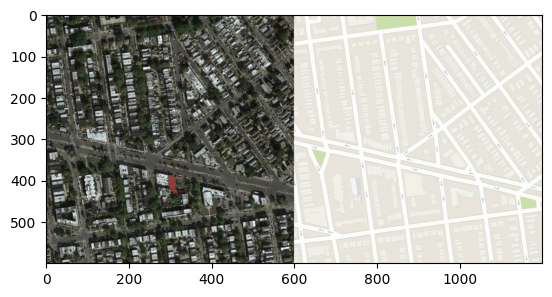

In [139]:
amostra = tf.io.read_file(str(caminho/"train/1.jpg"))
amostra = tf.io.decode_jpeg(amostra)
print(amostra.shape)
plt.figure()
plt.imshow(amostra)
plt.show()

## Pré processamento das imagenes

### Separar as imagens de satelite e de mapa

In [140]:
def carregar_imagens(caminho):
    img = tf.io.read_file(caminho)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize(img, [256, 512]) #redimensionando
    largura = tf.shape(img)[1]
    largura = largura // 2
    img_original = img[:, :largura, :]
    img_transformada = img[:, largura:, :]
    img_original = tf.cast(img_original, tf.float32)
    img_transformada = tf.cast(img_transformada, tf.float32)
    return img_original, img_transformada

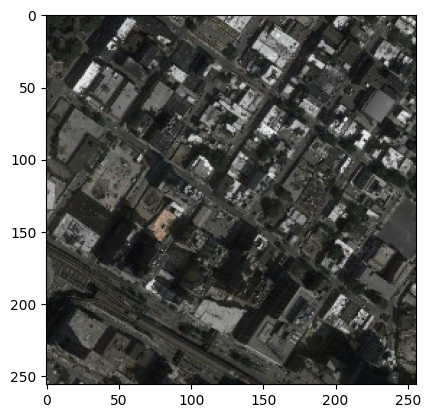

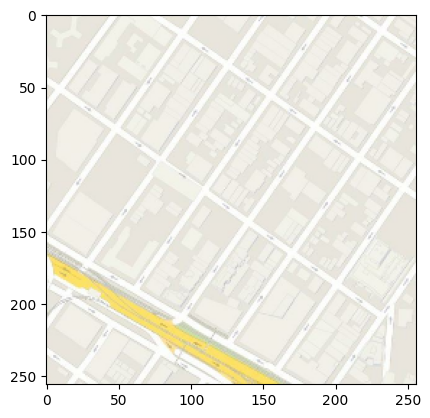

In [141]:
img_original, img_transformada = carregar_imagens(str(caminho / 'train/74.jpg'))
plt.figure()
plt.imshow(img_original / 255.0)
plt.figure()
plt.imshow(img_transformada / 255.0);

### Definindo quantidade de imagens de treinamento

In [142]:
qtd_train = tf.data.Dataset.list_files(str(caminho / 'train/*jpg'))
qtd_train

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [143]:
qtd_train = len(list(qtd_train))
qtd_train

1096

### Redimensionando imagem

In [144]:
buffer_size = qtd_train
batch_size = 1
img_largura = 256
img_altura = 256

def redimensionar(img_original, img_transformada, altuta, largura):
    img_original = tf.image.resize(img_original, [img_largura, img_altura], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    img_transformada = tf.image.resize(img_transformada, [img_largura, img_altura], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img_original, img_transformada

### Normalizando os pixels
- Originalmente estão na escala entre 0 e 255
- Vamos colocar na escala -1 e 1 com o objetivo de facilitar o treinamento

In [145]:
def normalizar(img_original, img_transformada):
    img_original = (img_original / 127.5) - 1
    img_transformada = (img_transformada / 127.5) - 1
    return img_original, img_transformada

### Função para selecionar apenas uma parte da imagem
- é como se estivéssimos dando zoom em uma parte

In [146]:
def random_crop(img_original, img_transformada):
    img_empilhada = tf.stack([img_original, img_transformada], axis = 0)
    img_crop = tf.image.random_crop(img_empilhada, size = [2, img_largura, img_altura, 3])
    return img_crop[0], img_crop[1]

### Realizando Data Augmentation em duas imagens associadas, ou seja, na imagem de satelite e de mapa

In [147]:
@tf.function
def random_jitter(img_original, img_transformada):
  img_original, img_transformada = redimensionar(img_original, img_transformada, 286, 286)
  img_original, img_transformada = random_crop(img_original, img_transformada)
  if tf.random.uniform(()) > 0.5:
    img_original = tf.image.flip_left_right(img_original)
    img_transformada = tf.image.flip_left_right(img_transformada)
  return img_original, img_transformada

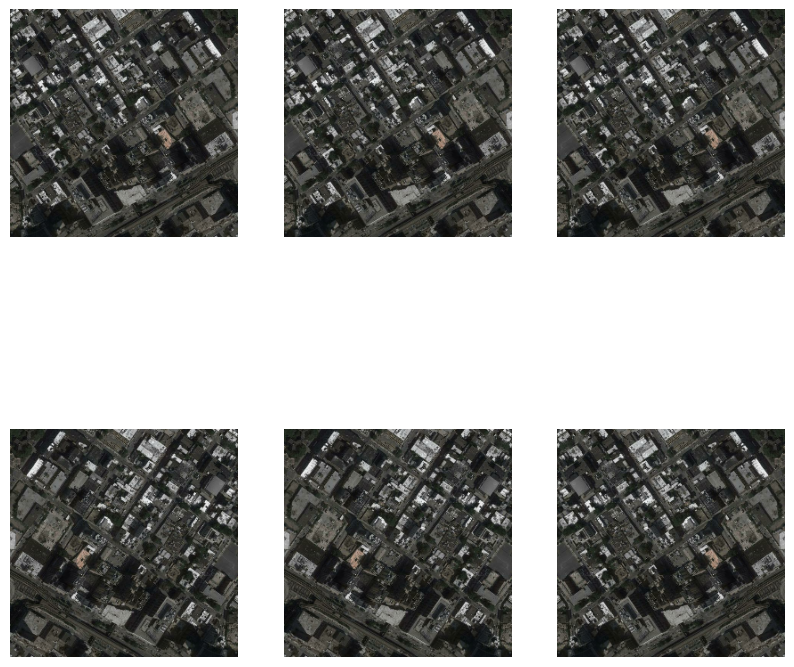

In [148]:
plt.figure(figsize=(10, 10))
for i in range(6):
  j_original, j_transformada = random_jitter(img_original, img_transformada)
  plt.subplot(2,3, i + 1)
  plt.imshow(j_original / 255.0)
  plt.imshow(j_original / 255.0)
  plt.axis('off')
plt.show()

### Carregando todo o dataset com as funções criadas

In [149]:
def load_train(img_arquivo):
  img_original, img_transformada = carregar_imagens(img_arquivo)
  img_original, img_transformada = random_jitter(img_original, img_transformada)
  img_original, img_transformada = normalizar(img_original, img_transformada)
  return img_original, img_transformada

In [150]:
def load_test(img_arquivo):
  img_original, img_transformada = carregar_imagens(img_arquivo)
  img_original, img_transformada = redimensionar(img_original, img_transformada, img_altura, img_largura)
  img_original, img_transformada = normalizar(img_original, img_transformada)
  return img_original, img_transformada

In [151]:
# Corrigir o dataset de treino
df_train = tf.data.Dataset.list_files(str(caminho / 'train/*jpg'))
df_train = df_train.map(load_train, num_parallel_calls=tf.data.AUTOTUNE)
df_train = df_train.shuffle(buffer_size).batch(batch_size)  # Removida a duplicação do batch

In [152]:
try:
  df_test = tf.data.Dataset.list_files(str(caminho / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  df_test = tf.data.Dataset.list_files(str(caminho / 'val/*.jpg'))
df_test = df_test.map(load_test)
df_test = df_test.batch(batch_size)

## Gerador
O gerador do pix2pix segue uma arquitetura de encoder-decoder com skip connections (similar a uma U-Net), que recebe como entrada a imagem de condição (por exemplo, um rascunho) e a transforma na imagem de saída desejada. Durante o encoding, a rede extrai características da imagem em múltiplos níveis de resolução, enquanto no decoding reconstrói a imagem em alta resolução, combinando informações de níveis anteriores por meio das conexões diretas (skips). Isso permite preservar detalhes finos e garantir que a saída seja fiel à estrutura do input.
- **Encoder**: O encoder do gerador no pix2pix é composto por uma série de **camadas de convolução e downsampling, reduzindo progressivamente a resolução da imagem e extraindo características em diferentes níveis**
- **Decoder:** o decoder faz o processo inverso, reconstruindo a imagem em alta resolução por meio de camadas de upsampling (ou transposed convolutions).

**Função de downsample / encode**
 * Convolution -> Batch normalization -> Leaky ReLU

In [153]:
#Downsample
def encoder(filters, size, apply_batchnorm = True):
  initializer = tf.random_normal_initializer(0, 0.02) #media, std (numeros aleatorios de iniciação dos pesos)
  resultado = tf.keras.Sequential()
  resultado.add(tf.keras.layers.Conv2D(filters, size, strides = 2, padding = 'same', kernel_initializer = initializer, use_bias = False))
  if apply_batchnorm:
    resultado.add(tf.keras.layers.BatchNormalization())
  resultado.add(tf.keras.layers.LeakyReLU())
  return resultado

In [154]:
down_model = encoder(3, 4)
down_result = down_model(tf.expand_dims(img_original, 0))
print(down_result.shape)

(1, 128, 128, 3)


**Função de upsample / decode**
 * Transposed convolution -> Batch normalization -> Dropout (aplicado aos 3 primeiros blocos) -> ReLU

In [155]:
#Upsample
def decoder(filters, size, apply_dropout = False):
  initializer = tf.random_normal_initializer(0, 0.02) #media, std (numeros aleatorios de iniciação dos pesos)
  resultado = tf.keras.Sequential()
  resultado.add(tf.keras.layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same', kernel_initializer = initializer, use_bias = False))
  resultado.add(tf.keras.layers.BatchNormalization())
  if apply_dropout:
    resultado.add(tf.keras.layers.Dropout(0.5))
  resultado.add(tf.keras.layers.ReLU())
  return resultado

In [156]:
up_model = decoder(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [157]:
def Gerador():
  inputs = tf.keras.layers.Input(shape = [256, 256, 3])

  downsampling = [
      encoder(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
      encoder(128, 4),  # (batch_size, 64, 64, 128)
      encoder(256, 4),  # (batch_size, 32, 32, 256)
      encoder(512, 4),  # (batch_size, 16, 16, 512)
      encoder(512, 4),  # (batch_size, 8, 8, 512)
      encoder(512, 4),  # (batch_size, 4, 4, 512)
      encoder(512, 4),  # (batch_size, 2, 2, 512)
      encoder(512, 4),  # (batch_size, 1, 1, 512)
  ]

  upsampling = [
      decoder(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 512)
      decoder(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 512)
      decoder(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 512)
      decoder(512, 4),  # (batch_size, 16, 16, 512)
      decoder(256, 4),  # (batch_size, 32, 32, 256)
      decoder(128, 4),  # (batch_size, 64, 64, 128)
      decoder(64, 4),  # (batch_size, 128, 128, 64)
  ]

  canais_saida = 3
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(canais_saida, 4, strides=2, padding='same',
                                         kernel_initializer=initializer, activation = 'tanh')  # (batch_size, 256, 256, 3)

  x = inputs
  skips = []
  for down in downsampling:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  for up, skip in zip(upsampling, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)
  return tf.keras.Model(inputs = inputs, outputs = x)

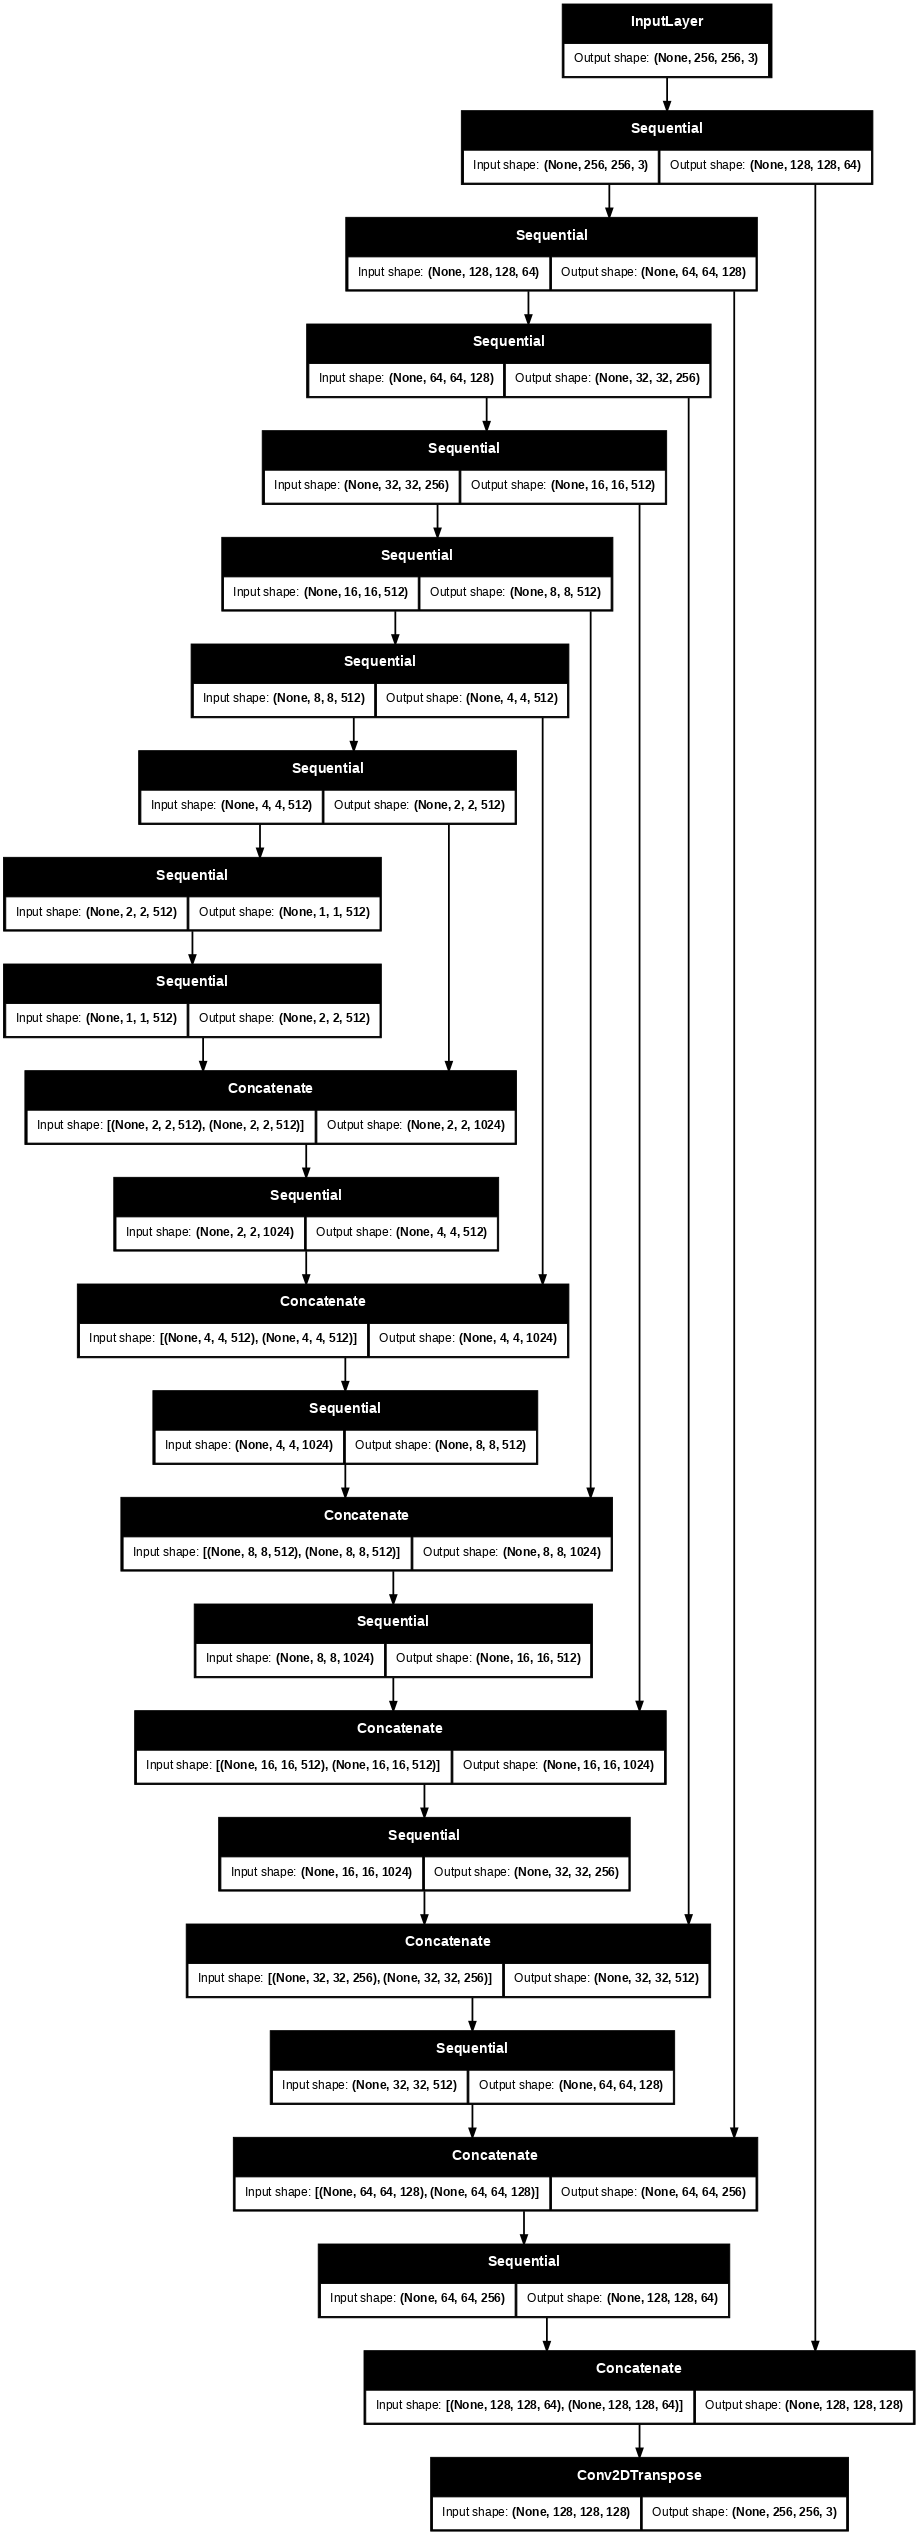

In [158]:
gerador = Gerador()
tf.keras.utils.plot_model(gerador, show_shapes = True, dpi = 64)

### Testando

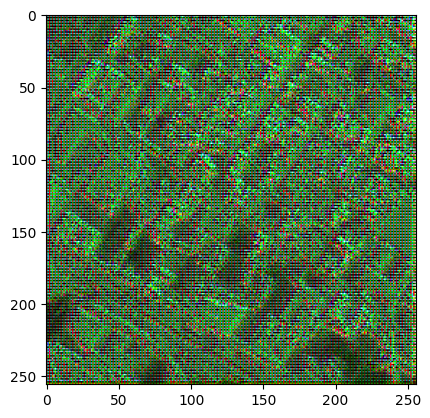

In [159]:
g_saida = gerador(img_original[tf.newaxis, ...], training = False)
plt.imshow(g_saida[0, ...])

### Loss Gerador
### Loss Adversarial (cGAN):
- O gerador é treinado para enganar o discriminador, fazendo com que a saída gerada pareça o mais realista possível.
- Formalmente, isso é expresso como uma função de custo que o gerador tenta minimizar, enquanto o discriminador tenta maximizar (o famoso minimax).
- No caso do Conditional GAN, o gerador também leva em conta a imagem de entrada (condição) para produzir a saída.

### Loss de Reconstrução (por exemplo, L1):

- Além de ser “realista”, a imagem gerada deve se parecer com a imagem-alvo (ground truth).
- Para isso, o pix2pix adiciona uma penalidade L1 (ou seja, a soma das diferenças absolutas entre os pixels da imagem gerada e da imagem real).
- Essa loss força o gerador a produzir imagens estruturalmente coerentes com o rótulo, evitando que ele gere apenas “algo realista” mas desconectado do input.


In [160]:
lr = 0.0002
beta1, beta2 = 0.5, 0.999
lambda_ = 100

loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def loss_gerador(d_saida_gerada, g_saida, target):
  gan_loss = loss(tf.ones_like(d_saida_gerada), d_saida_gerada)
  l1_loss = tf.reduce_mean(tf.abs(target - g_saida))
  g_loss_total = gan_loss + (lambda_ * l1_loss)
  return g_loss_total, gan_loss, l1_loss

## Discriminador
- No pix2pix, costuma-se usar um **PatchGAN**, que em vez de produzir uma única probabilidade de verdadeiro/falso para a imagem inteira, retorna uma matriz de probabilidades, onde cada “patch” (pequena região da imagem) é julgado individualmente.
-  Esse processo ajuda a rede a focar em detalhes locais e melhora a qualidade do resultado, pois o gerador precisa se preocupar em enganar o discriminador em vários patches, e não apenas produzir algo globalmente plausível.
- Lembrando a formação de cada bloco do discriminador: Convolution -> Batch normalization -> Leaky ReLU.

In [161]:
def Discriminador():
  initializer = tf.random_normal_initializer(0., 0.02)

  original = tf.keras.layers.Input(shape=[256,256,3], name = 'img_original')
  transformada = tf.keras.layers.Input(shape=[256,256,3], name = 'img_transformada')
  x = tf.keras.layers.concatenate([original, transformada]) # (batch_size, 256, 256, channels*2)

  down1 = encoder(64, 4, False)(x) # (batch_size, 128, 128, 64)
  down2 = encoder(128, 4)(down1) # (batch_size, 64, 64, 128)
  down3 = encoder(256, 4)(down2) # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias = False)(zero_pad1) # (batch_size, 31, 31, 512)
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (batch_size, 33, 33, 512)
  last = tf.keras.layers.Conv2D(1, 4, strides = 1, kernel_initializer=initializer)(zero_pad2) # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs = [original, transformada], outputs = last)

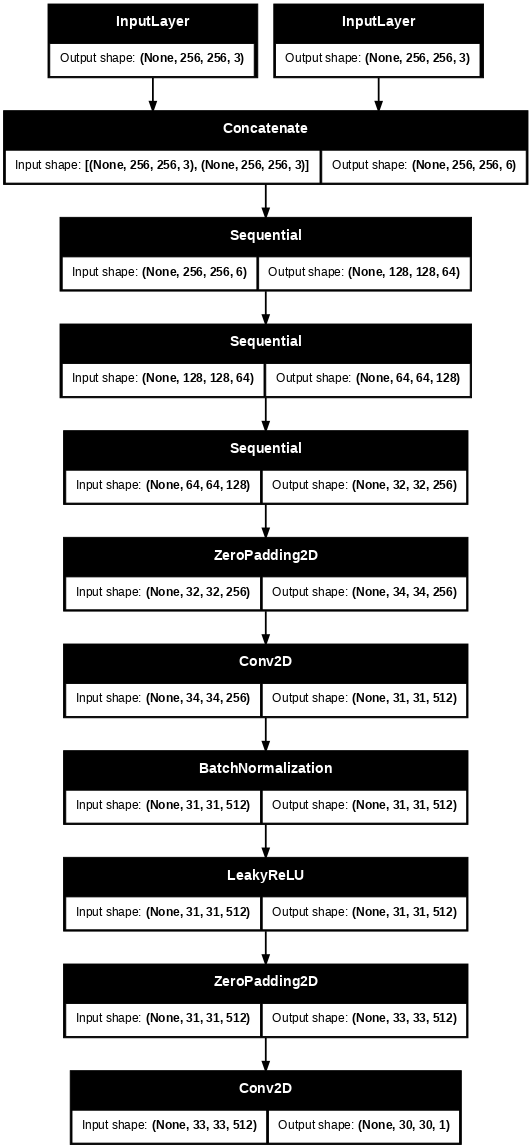

In [162]:
discriminador = Discriminador()
tf.keras.utils.plot_model(discriminador, show_shapes = True, dpi = 64)

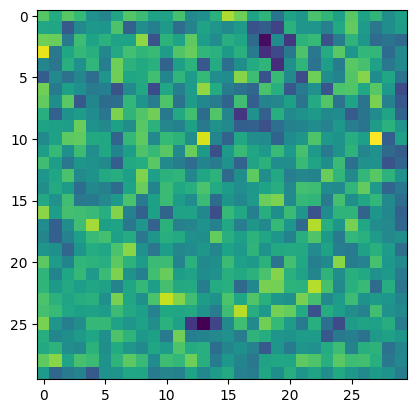

In [163]:
d_saida = discriminador([img_original[tf.newaxis, ...], g_saida], training=False)
plt.imshow(d_saida[0, ..., -1])

### Perda do discriminador
A loss do discriminador recebe como input:  imagens reais; imagens geradas.
* `loss_real` - sigmoid cross-entropy loss da imagem **real** e uma array de 1's
* `loss_gerada` - sigmoid cross-entropy loss da imagem **gerada** e uma array de 0's

Por fim, a loss total será a soma de loss_real e loss_gerada

In [164]:
def loss_discriminador(d_saida_real, d_saida_gerada):
  loss_real = loss(tf.ones_like(d_saida_real), d_saida_real)
  loss_gerada = loss(tf.zeros_like(d_saida_gerada), d_saida_gerada)
  d_loss_total = loss_real + loss_gerada
  return d_loss_total

### Optimizers

In [165]:
optimizer_gerador = tf.keras.optimizers.Adam(lr, beta_1=beta1, beta_2=beta2)
optimizer_discriminador = tf.keras.optimizers.Adam(lr, beta_1=beta1, beta_2=beta2)

### Checkpoint

In [166]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefixo = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = optimizer_gerador,
                                 discriminator_optimizer = optimizer_discriminador,
                                 generator = gerador,
                                 discriminator = discriminador)

### Função para gerar imagens no treinamento

In [167]:
def gerar_imagens(modelo, teste_entrada, real, etapa = None):
  gerada = modelo(teste_entrada, training=True)
  plt.figure(figsize=(12,8))
  lista_imgs = [teste_entrada[0], real[0], gerada[0]]
  titulo = ['Imagem de entrada', 'Real (ground truth)', 'Image gerada (fake)']
  for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(titulo[i])
    plt.imshow(lista_imgs[i] * 0.5 + 0.5)
    plt.axis('off')
  if etapa is not None:
    plt.savefig('resultado_pix2pix_etapa_{}.png'.format(etapa), bbox_inches='tight')
  plt.show()

#### Testando...

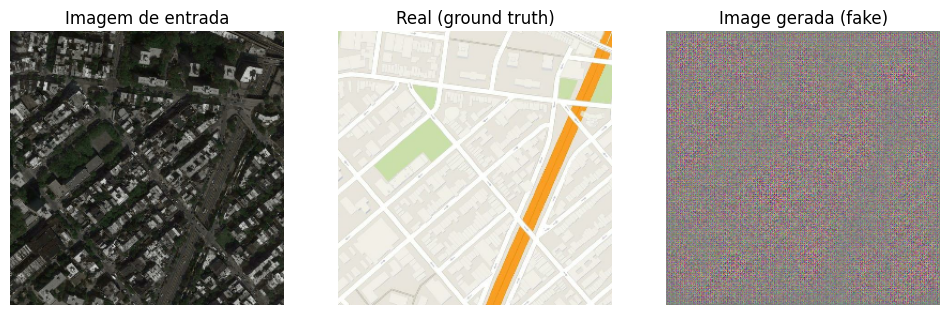

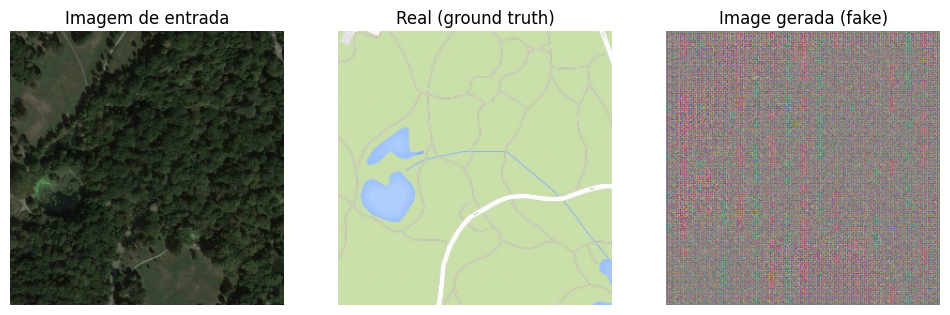

In [168]:
for entrada_exemplo, real_exemplo in df_test.take(2):
  gerar_imagens(gerador, entrada_exemplo, real_exemplo)

## Treinamento
* Para cada entrada gera-se uma saída.
* O discriminador recebe `img_entrada` e as imagens geradas como primeira entrada. A segunda entrada é img_entrada e a "real" (esperada)
* Em seguida, calcula-se a perda do gerador e discriminador (Abaixo definimos uma função para salvar o log)
* Então calcula-se os gradientes da perda em relação às variáveis do gerador e discriminador (entradas) e aplica essas ao optimizer.

In [169]:
caminho_log = 'logs/'
summary_writer = tf.summary.create_file_writer(
    caminho_log + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [170]:
@tf.function
def train_step(img_entrada, real, etapa):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        g_saida = gerador(img_entrada, training=True)
        d_saida_real = discriminador([img_entrada, real], training=True)
        d_saida_gerada = discriminador([img_entrada, g_saida], training=True)
        
        g_loss_total, g_loss_gan, g_loss_l1 = loss_gerador(d_saida_gerada, g_saida, real)
        d_loss = loss_discriminador(d_saida_real, d_saida_gerada)
        
    gradients_gerador = g_tape.gradient(g_loss_total, gerador.trainable_variables)
    gradients_discriminador = d_tape.gradient(d_loss, discriminador.trainable_variables)
    
    optimizer_gerador.apply_gradients(zip(gradients_gerador, gerador.trainable_variables))
    optimizer_discriminador.apply_gradients(zip(gradients_discriminador, discriminador.trainable_variables))
    
    # Correção do logging
    with summary_writer.as_default():
        step_idx = tf.cast(etapa, tf.int64)
        tf.summary.scalar('g_loss_total', g_loss_total, step=step_idx)
        tf.summary.scalar('g_loss_gan', g_loss_gan, step=step_idx)
        tf.summary.scalar('g_loss_l1', g_loss_l1, step=step_idx)
        tf.summary.scalar('d_loss', d_loss, step=step_idx)

Tempo para executar 1000 etapas: 120.56 segundos



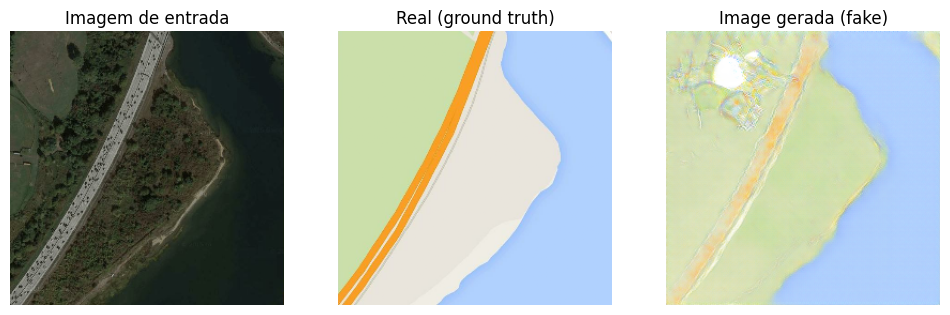

Etapa: 24K
....................................................................................................

In [173]:
def treinar(df_train, df_test, etapas):
    entrada_exemplo, exemplo_real = next(iter(df_test.take(1)))
    inicio = time.time()

    for etapa, (img_entrada, real) in df_train.repeat().take(etapas).enumerate():
        if etapa % 1000 == 0:
            display.clear_output(wait=True)
            if etapa != 0:
                print(f'Tempo para executar 1000 etapas: {time.time() - inicio:.2f} segundos\n')
            inicio = time.time()
            gerar_imagens(gerador, entrada_exemplo, exemplo_real, etapa)
            print(f"Etapa: {etapa//1000}K")
        
        train_step(img_entrada, real, etapa)
        
        if (etapa + 1) % 10 == 0:
            print('.', end='', flush=True)
        if (etapa + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefixo)
            gerador.save_weights('modelo_pix2pix.weights.h5')

# Iniciar o treinamento
treinar(df_train, df_test, etapas=25000)

In [176]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt-6'

In [177]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [182]:
modelo_pretreinado = Gerador()
modelo_pretreinado.load_weights('/kaggle/working/modelo_pix2pix.weights.h5')

## Visualização das imagens geradas

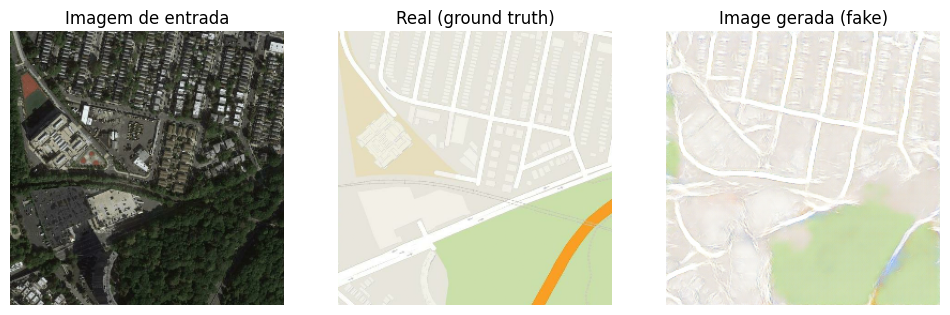

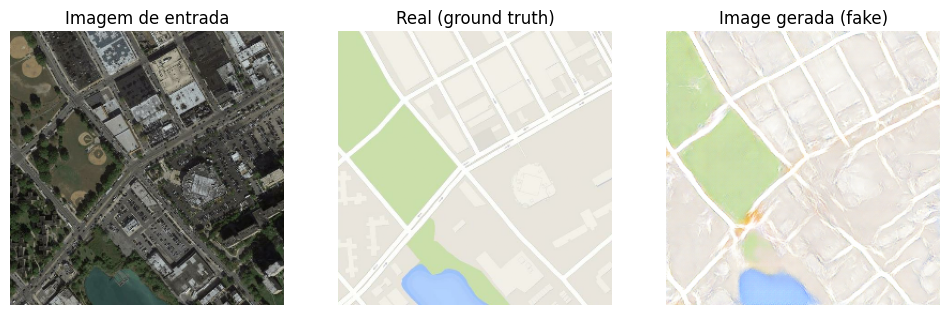

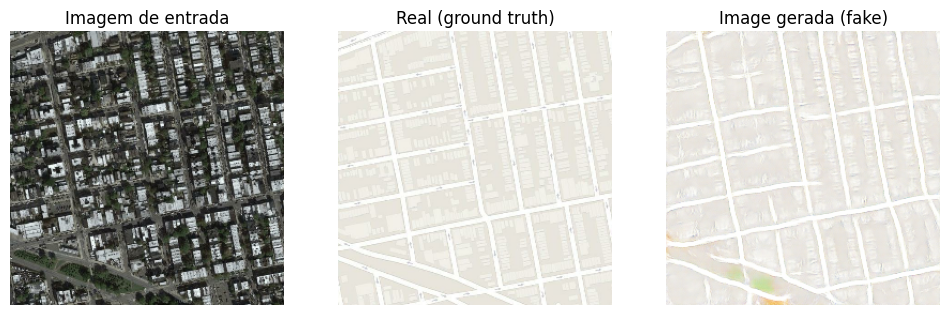

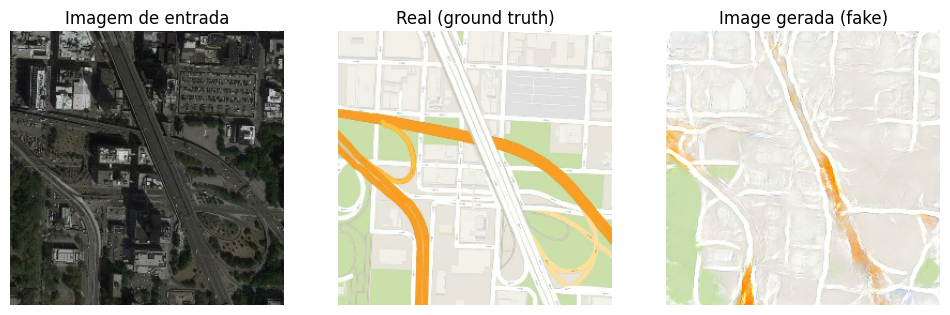

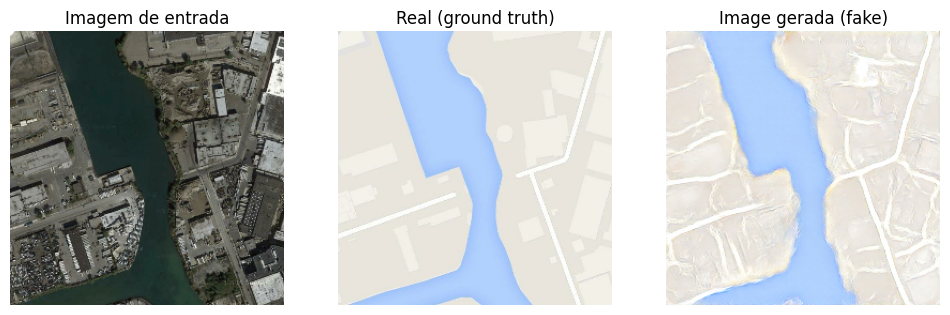

In [187]:
for satelite, mapa in df_test.take(5):
  gerar_imagens(modelo_pretreinado, satelite, mapa)